### Data Analysis

In [1]:
import cv2
import gc
from scipy.misc import imread
import numpy as np
from io import BytesIO
from glob import glob
import matplotlib.pyplot as plt
import scipy.io as sio
from plotly.offline import iplot
import plotly.graph_objs as go
import numpy as np
import warnings
from concurrent.futures import ThreadPoolExecutor
from keras.utils.np_utils import to_categorical
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
data = sio.loadmat('cars_annos.mat').get('annotations')[0]

In [3]:
class Image(np.ndarray):
    
    def __new__(cls,data):
        
        path = data[0].item()
        
        bbox_x1, bbox_y1, bbox_x2, bbox_y2 = list(data)[1:5]
        
        im = imread(path)[bbox_y1.item():bbox_y2.item(), bbox_x1.item():bbox_x2.item()]
        
        return np.asarray(im).view(cls)
    
    
    def __init__(self,data):
        
        self.path = data[0].item()
        
        self.valid = self.shape[-1] == 3 #make sure it's a real photo (RGB = 3)
        
        self.shape_dict = {}
        
        self.shape_dict["length"] = self.shape[0]
        
        self.shape_dict["width"] = self.shape[1]
        
        self.shape_dict["channel"] = self.shape[2] if self.valid else 0
        
        self.label = data[5].item() # puts the type of the car in a tuple
        
        self.test = data[6].item() == True #put the image in the training set
        
        self.train = not self.test #put the image in the test set

In [ ]:
%%time
with ThreadPoolExecutor() as executor:
    images = list(executor.map(Image,data))
        

In [ ]:
labels_name = sio.loadmat('cars_annos.mat')['class_names'][0]

In [ ]:
id_to_name_map = dict(zip(range(len(labels_name)), labels_name))

In [ ]:
import pandas as pd
df = pd.DataFrame([image.shape_dict for image in images])

df["label"] = [image.label for image in images]

df['label_name'] = [id_to_name_map[image.label-1][0] for image in images]

df["path"] = [image.path for image in images]

### Alot of outliers.

In [ ]:
length = go.Box(
    y = df.length,
    name = "images lengths",
    boxpoints = 'suspectedoutliers',
    marker = dict(color = 'rgb(8,81,156)',outliercolor = 'rgba(219, 64, 82, 0.6)',
        line = dict(outliercolor = 'rgba(219, 64, 82, 0.6)',outlierwidth = 2)),
    line = dict(color = 'rgb(8,81,156)')
)
width = go.Box(
    y = df.width,
    name = "images width",
    boxpoints = 'suspectedoutliers',
    marker = dict(color = 'rgb(8,81,156)',outliercolor = 'rgba(219, 64, 82, 0.6)',
        line = dict(outliercolor = 'rgba(219, 64, 82, 0.6)',outlierwidth = 2)),
    line = dict(color = 'rgb(8,81,156)')
)

iplot(go.Figure(data=[length,width],layout=go.Layout(title = "Images Shapes Outliers")))

### Lets fix this

In [ ]:
df=df[(df.length>100) & (df.length<665)]

In [ ]:
df = df[(df.width>100) & (df.width<1137)]

## We will filter the images by choosing the images that have a length between 100 and 665 and width  :)

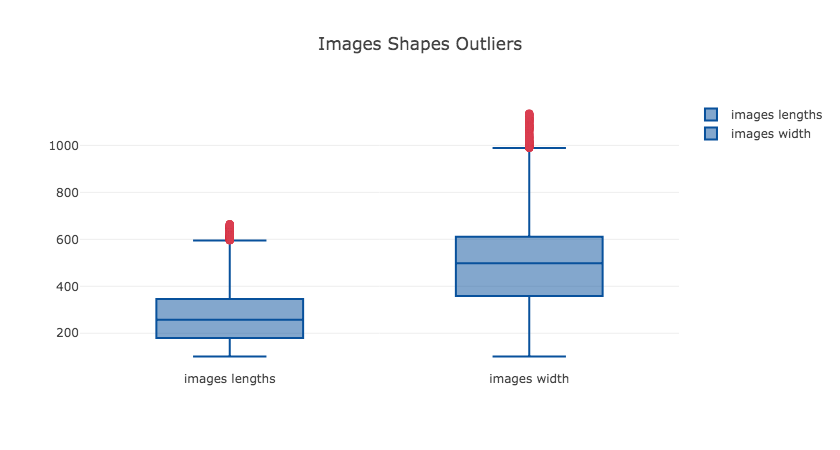

In [79]:
length = go.Box(
    y = df.length,
    name = "images lengths",
    boxpoints = 'suspectedoutliers',
    marker = dict(color = 'rgb(8,81,156)',outliercolor = 'rgba(219, 64, 82, 0.6)',
        line = dict(outliercolor = 'rgba(219, 64, 82, 0.6)',outlierwidth = 2)),
    line = dict(color = 'rgb(8,81,156)')
)
width = go.Box(
    y = df.width,
    name = "images width",
    boxpoints = 'suspectedoutliers',
    marker = dict(color = 'rgb(8,81,156)',outliercolor = 'rgba(219, 64, 82, 0.6)',
        line = dict(outliercolor = 'rgba(219, 64, 82, 0.6)',outlierwidth = 2)),
    line = dict(color = 'rgb(8,81,156)')
)

iplot(go.Figure(data=[length,width],layout=go.Layout(title = "Images Shapes Outliers")))

In [52]:
df['ratio'] = df.width/df.length
labels_dfs = {}


for label,df_ in df.groupby("label_name"):  #return a list of tuples(label, new df(label))
    labels_dfs[label] = df_

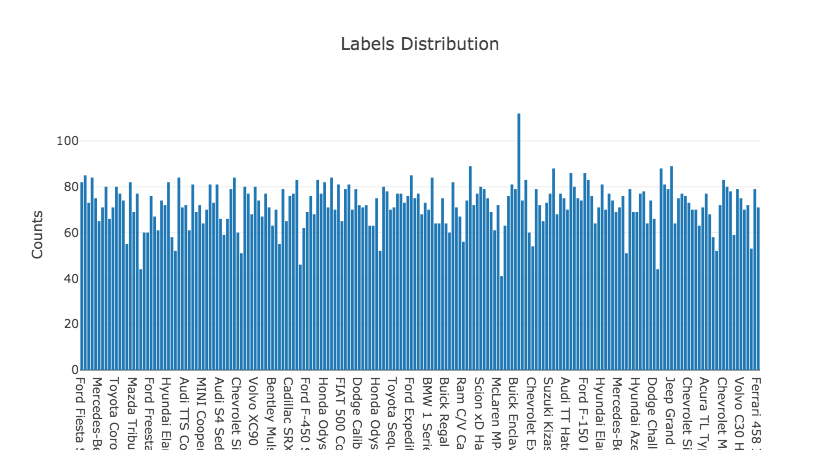

In [57]:
labels = list(labels_dfs.keys())  #keys = labels   , values = df
values = list([len(x) for x in labels_dfs.values()])

trace = go.Bar(x=[str(x) for x in labels], y=values)

iplot({"data":[trace],"layout":go.Layout(title="Labels Distribution",yaxis=dict(title="Counts"),
                                        )})

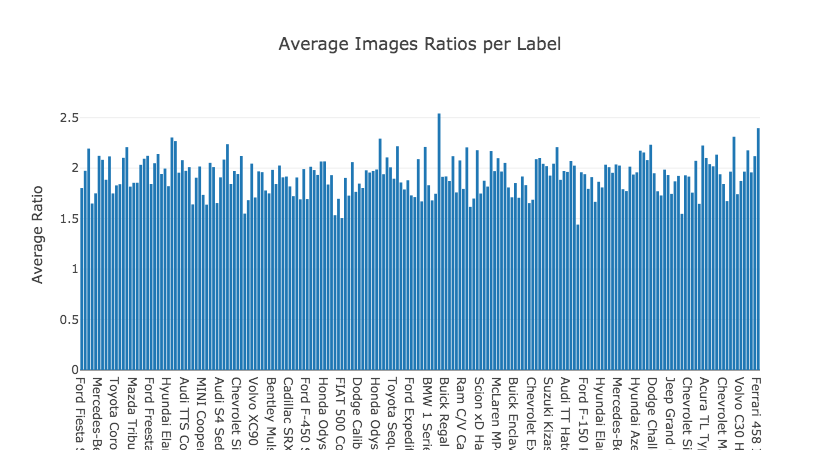

In [56]:
labels = list(labels_dfs.keys())
values = list([ (df.ratio).mean() for df in labels_dfs.values()])

trace = go.Bar(x=[str(x) for x in labels], y=values)

iplot({"data":[trace],"layout":go.Layout(title="Average Images Ratios per Label",
                                         yaxis=dict(title="Average Ratio"))}
                                        )

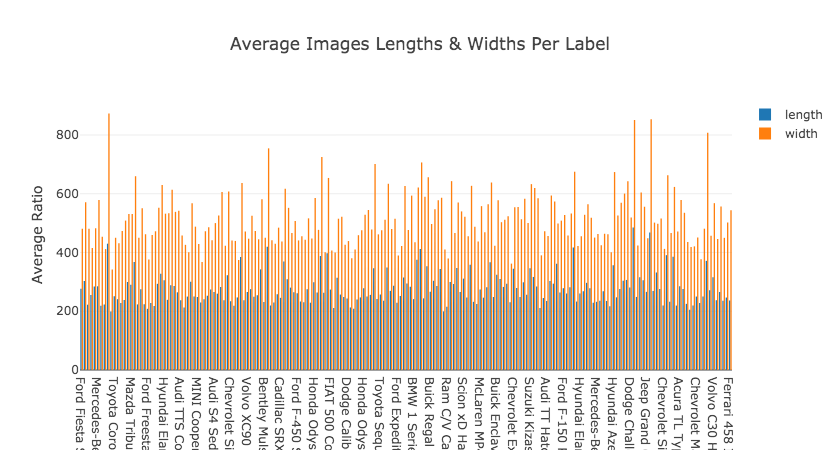

In [59]:
labels = list(labels_dfs.keys())

length = go.Bar(x=labels, y=list([ (df.length).mean() for df in labels_dfs.values()]),name="length")
width = go.Bar(x=labels, y=list([ (df.width).mean() for df in labels_dfs.values()]),name="width")

iplot({"data":[length,width],"layout":go.Layout(title="Average Images Lengths & Widths Per Label",yaxis=dict(title="Average Ratio"),
                                        barmode='group')})

In [60]:
global_width = int(df.width.mean())
global_length = int(df.length.mean())

In [61]:
global_width 

513

In [73]:
"hello world there is hi".rsplit(" ",2)

['hello world there', 'is', 'hi']

##  Lets visualize the images resized to the global width and length mean, now that we got rid of the outliers

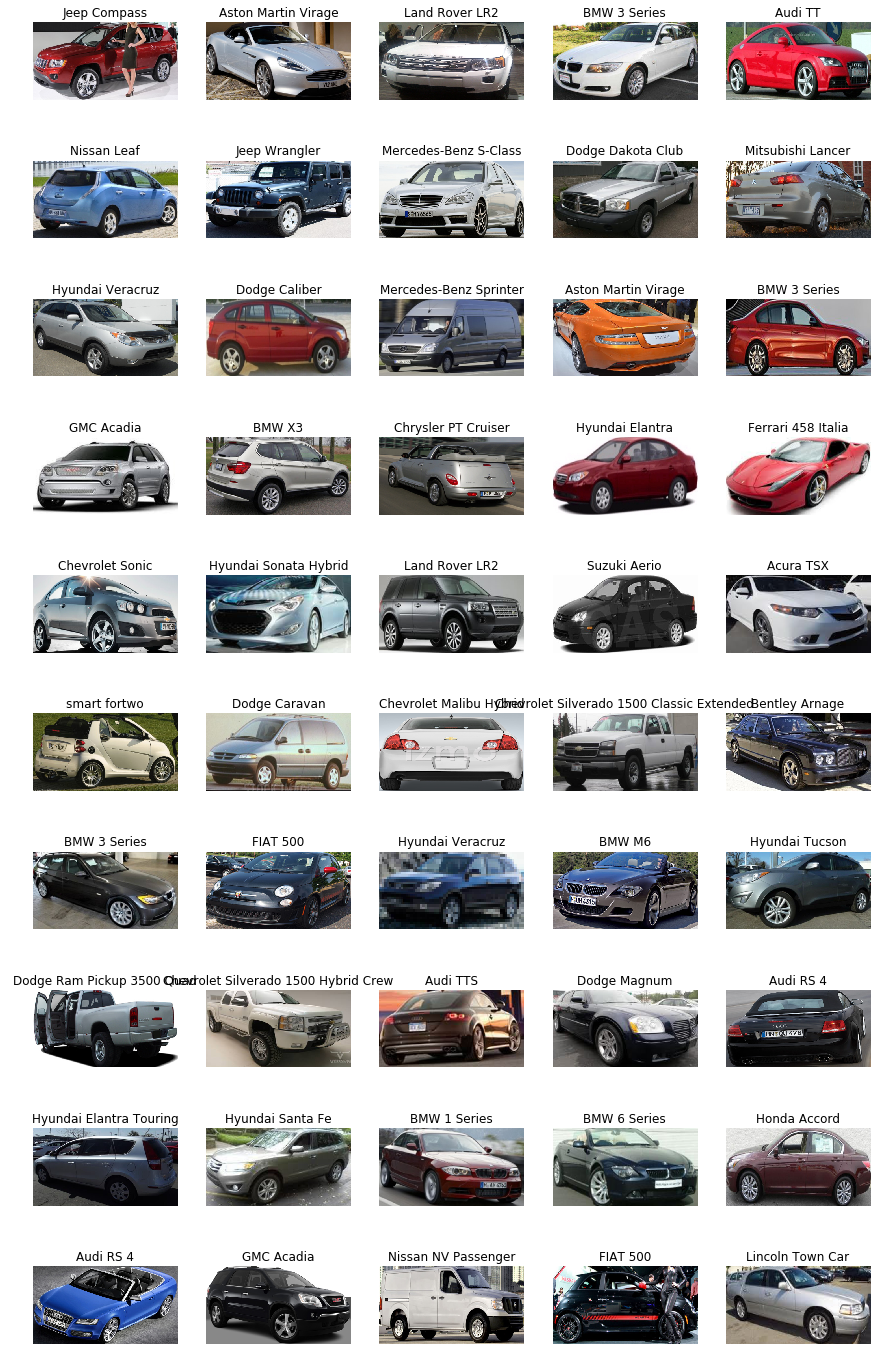

In [76]:
import random
rows, cols= 10, 5
plt.figure(figsize=(15, 25))
for row in range(rows):
    for col in range(cols):     
        image = random.choice(images) #random choice variable of the array
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.imshow(cv2.resize(image,(global_width,global_length)))
        plt.title(id_to_name_map[image.label-1][0].rsplit(" ",2)[0])
        plt.axis("off")


## Lets check if there are any wrong labels

In [96]:
import random
random_label = random.choice(list(labels_dfs.keys()))
rows, cols= 7, 3
plt.figure(figsize=(15, 25))
for row in range(rows):
    for col in range(cols):
        index = choice(labels_dfs[random_label].index.tolist())
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.imshow(cv2.resize(images[index],(global_width,global_length)))
        plt.title("Label: {}".format(images[index].label))
        plt.axis("off")
print("Label: ",str(random_label))

NameError: name 'choice' is not defined

<Figure size 1080x1800 with 0 Axes>

In [ ]:
random_label = choice(list(labels_dfs.keys()))
rows, cols= 7, 3
plt.figure(figsize=(15, 25))
for row in range(rows):
    for col in range(cols):
        index = choice(labels_dfs[random_label].index.tolist())
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.imshow(cv2.resize(images[index],(global_width,global_length)))
        plt.title("Label: {}".format(images[index].label))
        plt.axis("off")
print("Label: ",str(random_label))

we dont want the color of the car and background to have an effect of what label it is

In [ ]:
random_label = choice(list(labels_dfs.keys()))
rows, cols= 7, 3
plt.figure(figsize=(15, 25))
for row in range(rows):
    for col in range(cols):
        index = choice(labels_dfs[random_label].index.tolist())
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.imshow(cv2.resize(images[index],(global_width,global_length)))
        plt.title("Label: {}".format(images[index].label))
        plt.axis("off")
print("Label: ",str(random_label))

In [ ]:
random_label = choice(list(labels_dfs.keys()))
rows, cols= 7, 3
plt.figure(figsize=(15, 25))
for row in range(rows):
    for col in range(cols):
        index = choice(labels_dfs[random_label].index.tolist())
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.imshow(cv2.resize(images[index],(global_width,global_length)))
        plt.title("Label: {}".format(images[index].label))
        plt.axis("off")
print("Label: ",str(random_label))

In [ ]:
random_label = choice(list(labels_dfs.keys()))
rows, cols= 7, 3
plt.figure(figsize=(15, 25))
for row in range(rows):
    for col in range(cols):
        index = choice(labels_dfs[random_label].index.tolist())
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.imshow(cv2.resize(images[index],(global_width,global_length)))
        plt.title("Label: {}".format(images[index].label))
        plt.axis("off")
print("Label: ",str(random_label))

In [ ]:
random_label = choice(list(labels_dfs.keys()))
rows, cols= 7, 3
plt.figure(figsize=(15, 25))
for row in range(rows):
    for col in range(cols):
        index = choice(labels_dfs[random_label].index.tolist())
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.imshow(cv2.resize(images[index],(global_width,global_length)))
        plt.title("Label: {}".format(images[index].label))
        plt.axis("off")
print("Label: ",str(random_label))

In [ ]:
random_label = choice(list(labels_dfs.keys()))
rows, cols= 7, 3
plt.figure(figsize=(15, 25))
for row in range(rows):
    for col in range(cols):
        index = choice(labels_dfs[random_label].index.tolist())
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.imshow(cv2.resize(images[index],(global_width,global_length)))
        plt.title("Label: {}".format(images[index].label))
        plt.axis("off")
print("Label: ",str(random_label))

In [ ]:
random_label = choice(list(labels_dfs.keys()))
rows, cols= 7, 3
plt.figure(figsize=(15, 25))
for row in range(rows):
    for col in range(cols):
        index = choice(labels_dfs[random_label].index.tolist())
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.imshow(cv2.resize(images[index],(global_width,global_length)))
        plt.title("Label: {}".format(images[index].label))
        plt.axis("off")
print("Label: ",str(random_label))

From visual inspection, the labels looks ok. Though there are some cars within the same label that have minor differences. Though there are alot of labels that are van cars which are similar in shape but different in labels. Also, there are high variety in cars colors, maybe it would be a good idea to transform the images to greyscale rathen than RGB.   +background

##  Lets try visualizing the images in 2D greyscale 

In [ ]:
label = 192
rows, cols= 7, 3
plt.figure(figsize=(15, 25))
for row in range(rows):
    for col in range(cols):
        index = choice(labels_dfs[label].index.tolist())
        plt.subplot(rows, cols, row * cols + col + 1)
        image = cv2.resize(images[index],(global_width,global_length))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),cmap='gray')
        plt.title("Label: {}".format(images[index].label))
        plt.axis("off")
print("Label: ",str(random_label))
